### Credit Risk Modeling with Expert LLM Reporting

This notebook performs classification on credit risk customers using three robust models:

- Random Forest
- XGBoost
- Deep Learning (Keras Sequential)

I aim to **maximize recall**, ensuring high-risk customers are not misclassified as low-risk. SMOTE is used for class rebalancing.

At the end, a **local LLM (Mistral via Ollama)** will interpret performance metrics, confusion matrices, and feature importance plots.

[**Data Source:** Kaggle - Credit Risk Customers](https://www.kaggle.com/datasets/ppb00x/credit-risk-customers/data)

**Dataset Overview:** The dataset contains information on customers, including demographic details, financial status, and credit history. The target variable, `class`, indicates whether a customer is at high risk - bad (1) or low risk - good (0). Class imbalance is evident in the dataset (`class` has more 1s than 0s). To mitigate this, I use SMOTE to oversample the minority class.


#### 1. Load Libraries and Data
**Steps:**
1. Load dependencies and the dataset.
2. Visualize the df and check for missing values (none found in this dataset).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

os.makedirs("results", exist_ok=True)

In [3]:
# Load Data
df = pd.read_csv("data/credit_customers.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (1000, 21)


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [4]:
df.info()
# df.describe()  
# df.isnull().sum().plot(kind="barh")

# No missing found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

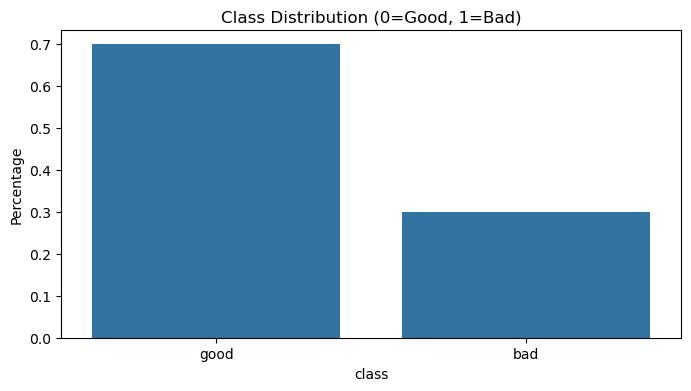

Class balance:
class
good    700
bad     300
Name: count, dtype: int64


In [5]:
# Class distribution analysis
class_dist = df['class'].value_counts(normalize=True)
plt.figure(figsize=(8,4))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution (0=Good, 1=Bad)')
plt.ylabel('Percentage')
plt.savefig('results/class_distribution.png')
plt.show()

print(f"Class balance:\n{df['class'].value_counts()}")

#### 2. Data Preprocessing
**Steps:**
1. Split the `personal_status` column into `sex` and `marital_status`.
2. Apply ordinal encoding to categorical variables.
3. Scale numerical features using `StandardScaler`.

In [6]:
# Divide "personal_status" column into two different columns
df[["sex", "marital_status"]]=df.personal_status.str.split(expand=True)
df.drop(columns=["personal_status"], inplace=True)
print(df.marital_status.value_counts())

marital_status
single         548
div/dep/mar    310
mar/wid         92
div/sep         50
Name: count, dtype: int64


**Split Data and Scale**

In [7]:
X = df.drop(columns='class')
y = df['class'].map({'good': 0, 'bad': 1})

categoricals = X.select_dtypes(include='object').columns
X[categoricals] = OrdinalEncoder().fit_transform(X[categoricals])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

#### 3. Model Evaluation

In [8]:
def evaluate_model(name, y_true, y_pred, y_proba, save_prefix):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"results/{save_prefix}_classification_report.csv")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"results/{save_prefix}_confusion_matrix.png")
    plt.clf()

    roc = roc_auc_score(y_true, y_proba)
    with open(f"results/{save_prefix}_roc_auc.txt", "w") as f:
        f.write(f"{name} ROC AUC: {roc:.4f}")

    return report['1']['recall']

#### 4. GridSearchCV for Random Forest and XGBoost

In [ ]:
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

rf_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=3, scoring='recall', n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:, 1]
recall_rf = evaluate_model("Random Forest (Tuned)", y_test, rf_pred, rf_proba, "rf_tuned")

xgb_search = GridSearchCV(xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                          param_grid={
                              'n_estimators': [100, 200],
                              'max_depth': [3, 5, 10],
                              'learning_rate': [0.01, 0.1, 0.2]
                          },
                          cv=3, scoring='recall', n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
recall_xgb = evaluate_model("XGBoost (Tuned)", y_test, xgb_pred, xgb_proba, "xgb_tuned")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

<Figure size 640x480 with 0 Axes>

#### 5. Train Deep Learning Model 

In [ ]:
dl = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])
dl.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32,
        callbacks=[EarlyStopping(patience=5, monitor='val_recall', mode='max', restore_best_weights=True)])

dl_pred = (dl.predict(X_test) > 0.5).astype(int).flatten()
dl_proba = dl.predict(X_test).flatten()
recall_dl = evaluate_model("Deep Learning", y_test, dl_pred, dl_proba, "dl")

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Recall: 0.2000 - loss: 0.6827 - val_Recall: 0.0619 - val_loss: 0.8981
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Recall: 0.1734 - loss: 0.6484 - val_Recall: 0.3190 - val_loss: 0.7866
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.2036 - loss: 0.6073 - val_Recall: 0.4571 - val_loss: 0.7437
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Recall: 0.3636 - loss: 0.5976 - val_Recall: 0.6048 - val_loss: 0.6725
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.4593 - loss: 0.5492 - val_Recall: 0.6143 - val_loss: 0.6653
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Recall: 0.5100 - loss: 0.5465 - val_Recall: 0.6381 - val_loss: 0.6476
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Recall: 0.4926 - loss: 0.5420 - val_Recall: 0.7000 - val_loss: 0.6069
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Recall: 0.5642 - loss: 0.5239 - val_Recall: 0.7286 - val_loss: 0.5724
Epoch 9/20
27/27 ━━━━━━

<Figure size 640x480 with 0 Axes>

#### 5. Compare Recalls

In [ ]:
print("Recall Scores:")
print(f"Random Forest (Tuned): {recall_rf:.4f}")
print(f"XGBoost (Tuned):       {recall_xgb:.4f}")
print(f"Deep Learning:         {recall_dl:.4f}")

Recall Scores:
Random Forest: 0.4933
XGBoost:       0.5467
Deep Learning: 0.5200


In [ ]:
"""
# Generating LLM Analysis with Ollama

Use the following shell command locally to generate an LLM-based expert report:

```bash
ollama run mistral "Generate an expert interpretation of the following metrics and plots saved in ./results: classification_report.csv, confusion_matrix.png, and roc_auc.txt for 3 models: Random Forest, XGBoost, Deep Learning. Summarize which model is most appropriate for high-risk detection based on recall."
```
"""

'\n# Generating LLM Analysis with Ollama\n\nUse the following shell command locally to generate an LLM-based expert report:\n\n```bash\nollama run mistral "Generate an expert interpretation of the following metrics and plots saved in ./results: classification_report.csv, confusion_matrix.png, and roc_auc.txt for 3 models: Random Forest, XGBoost, Deep Learning. Summarize which model is most appropriate for high-risk detection based on recall."\n```\n'

#### 6. Expert Analysis with Mistral
**Automated Insights:**
Using local Ollama Mistral to generate professional analysis

In [ ]:
def generate_expert_analysis():
    client = Client(host='http://localhost:11434')
    
    with open("results/model_metrics.json") as f:
        metrics = json.load(f)
    
    prompt = f"""
    As a senior financial economist, analyze these credit risk model results:
    {json.dumps(metrics, indent=2)}
    
    Focus on:
    1. Business implications of the recall/precision tradeoff
    2. Effectiveness of SMOTE for this 70/30 imbalance
    3. Model selection recommendations for a bank
    4. Limitations and next steps
    
    Provide concise, professional analysis suitable for executive stakeholders.
    """
    
    response = client.generate(model='mistral', prompt=prompt)
    
    os.makedirs("analysis", exist_ok=True)
    with open("analysis/expert_summary.md", "w") as f:
        f.write(response["response"])
    
    return response["response"]

print("Generating expert analysis...")
print(generate_expert_analysis())

Tuning Random Forest (SMOTE)...
Tuning Logistic Reg. (SMOTE)...
Tuning Neural Network (SMOTE)...
Tuning TF Deep Learning (SMOTE)...
7/7 [==============================] - 0s 2ms/step
